In [1]:
import pyreadr 
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

features = list(data_ml.columns[2:95])
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

<Axes: xlabel='Lambda', ylabel='Beta'>

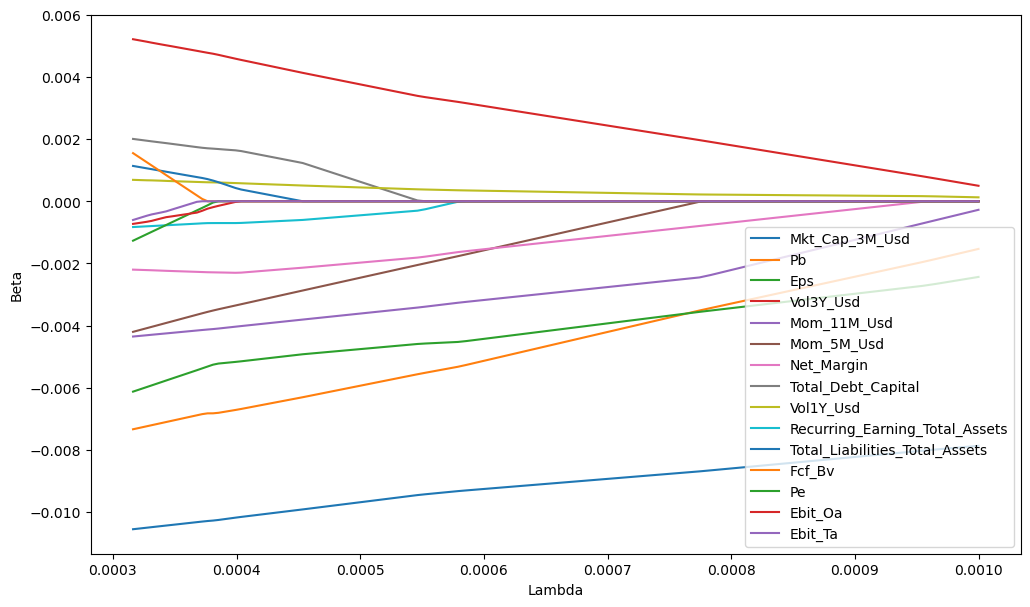

In [3]:
y_penalized = data_ml['R1M_Usd'] 
X_penalized = data_ml[features]

lambdas = np.logspace(-3.5,-3, num=100) #np.logspace(-3,-2, num=100) 
coefs = {}
for _lambda in lambdas:
    model = Lasso(alpha=_lambda).fit(X_penalized, y_penalized)
    coefs[_lambda] = model.coef_
lasso_res = pd.DataFrame(coefs).T
lasso_res.columns = features
predictors = lasso_res.abs().sum().nlargest(15).index
lasso_res.loc[:,predictors].plot(xlabel='Lambda',ylabel='Beta',figsize=(12,7))

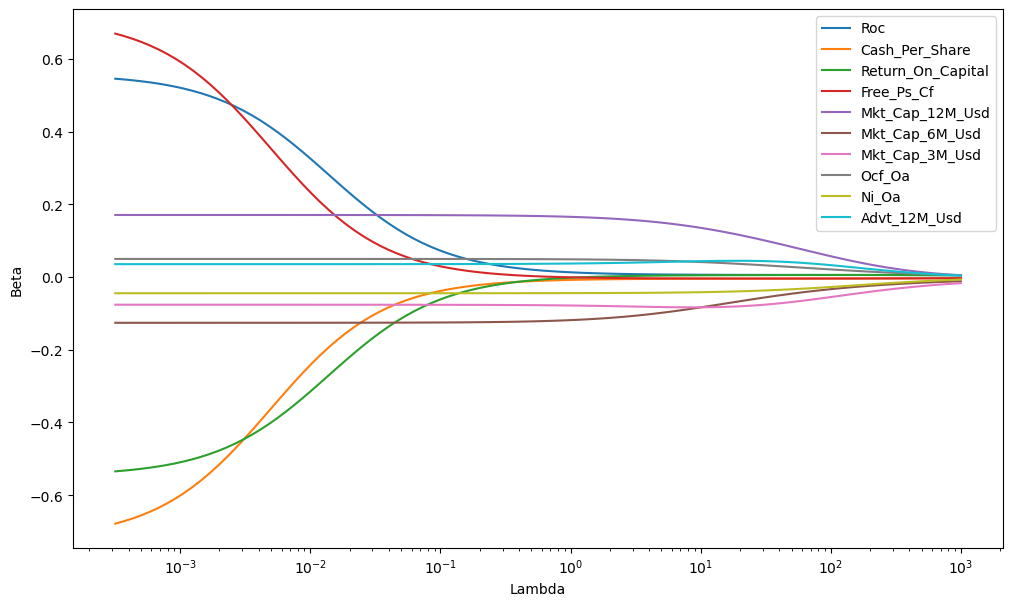

In [4]:
lambdas = np.logspace(-3.5,3, num=100) #np.logspace(-3,-2, num=100) 
coefs = {}
for _lambda in lambdas:
    model = Ridge(alpha=_lambda).fit(X_penalized, y_penalized)
    coefs[_lambda] = model.coef_
ridge_res = pd.DataFrame(coefs).T
ridge_res.columns = features
predictors = ridge_res.abs().sum().nlargest(10).index
ridge_res.loc[:,predictors].plot(xlabel='Lambda',ylabel='Beta',figsize=(12,7))
plt.xscale('log')

In [5]:
t_oos = returns.index[returns.index > separation_date].unique()
Tt = len(t_oos)  
nb_port = 3      

portf_weights = np.zeros((Tt, nb_port, returns.shape[1]))  
portf_returns = np.zeros((Tt, nb_port)) 


In [6]:
def weights_sparsehedge(returns, alpha, lambda_):
    w = []
    for i in range(returns.shape[1]):
        y = returns.iloc[:, i].values  
        X = returns.drop(returns.columns[i], axis=1).values

        model = ElasticNet(alpha=alpha, l1_ratio=lambda_, fit_intercept=True)
        model.fit(X, y)
        
        err = y - model.predict(X)  
        w.append( (1 - np.sum(model.coef_)) / np.var(err) ) 
    
    return w / np.sum(w)  

In [7]:
def weights_multi(returns, j, alpha=0.5, lambda_=0.1):
    N = returns.shape[1]
    
    if j == 0: # EW
        return np.ones(N) / N
    
    elif j == 1:  # Minimum Variance
        sigma = returns.cov().values + 0.01 * np.eye(N) 
        w = np.linalg.solve(sigma, np.ones(N))  
        return w / np.sum(w) 
    
    elif j == 2:  # Elastic Net
        return weights_sparsehedge(returns, alpha, lambda_)
    else:
        print("j should be 1, 2 or 3")


In [8]:
for t in range(Tt):
     temp_data = returns.loc[returns.index < t_oos[t]] 
     realised_returns = returns.loc[returns.index == t_oos[t]]  
     for j in range(nb_port): 
          portf_weights[t, j, :] = weights_multi(temp_data, j, 0.1, 0.1)  
          portf_returns[t, j] = np.sum(portf_weights[t, j, :] * realised_returns.values)  

portf_returns_df = pd.DataFrame(portf_returns, columns=["EW", "MV", "Sparse"])
portfolio_volatilities = portf_returns_df.std()  
print(portfolio_volatilities)

EW        0.041804
MV        0.033504
Sparse    0.034882
dtype: float64


In [9]:
y_penalized_train = training_sample['R1M_Usd'].values 
X_penalized_train = training_sample[features].values
model = ElasticNet(alpha=0.1, l1_ratio=0.1) 
fit_pen_pred=model.fit(X_penalized_train  , y_penalized_train) 

In [10]:
y_penalized_test = testing_sample['R1M_Usd'].values 
X_penalized_test = testing_sample[features].values
np.mean((fit_pen_pred.predict(X_penalized_test) - y_penalized_test)**2)


0.03699695809185004

In [11]:
np.mean(fit_pen_pred.predict(X_penalized_test) * y_penalized_test > 0)


0.5460346399270738